# GSF Training Model

In [1]:
import pandas as pd
import random
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
import selfies as sf
import group_selfies as gsf
from rdkit import Chem
import shap

random.seed(42)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [33]:
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
import rdkit.Chem.Draw as Draw
from rdkit.Chem.Draw import IPythonConsole

from IPython.display import display
from rdkit import RDLogger

RDLogger.DisableLog("rdApp.*")

##from https://sourceforge.net/p/rdkit/mailman/rdkit-discuss/thread/CAHGTkV8sdfb4Q7FLn9C5MTwrqiJjHtnXK%2Bmz2SY3_4j2eAtevQ%40mail.gmail.com/#msg36477772
from rdkit.Chem.Draw import rdMolDraw2D

try:
    import Image
except ImportError:
    from PIL import Image
from io import BytesIO


def DrawMolsZoomed(
    mols, legends, molsPerRow=3, subImgSize=(300, 300)
):  # , leg): #https://www.rdkit.org/docs/source/rdkit.Chem.Draw.rdMolDraw2D.html#rdkit.Chem.Draw.rdMolDraw2D.MolDraw2D
    nRows = len(mols) // molsPerRow
    if len(mols) % molsPerRow:
        nRows += 1
    fullSize = (molsPerRow * subImgSize[0], nRows * subImgSize[1])
    full_image = Image.new("RGBA", fullSize)
    for ii, mol in enumerate(mols):
        if mol.GetNumConformers() == 0:
            AllChem.Compute2DCoords(mol)
        le = legends[ii]
        column = ii % molsPerRow
        row = ii // molsPerRow
        offset = (column * subImgSize[0], row * subImgSize[1])
        d2d = rdMolDraw2D.MolDraw2DCairo(subImgSize[0], subImgSize[1])
        d2d.DrawMolecule(mol, legend=le)
        d2d.FinishDrawing()
        sub = Image.open(BytesIO(d2d.GetDrawingText()))
        full_image.paste(sub, box=offset)
    return full_image


In [2]:

import optuna
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    make_scorer,
    roc_curve,
    auc,
    hamming_loss,
    jaccard_score,
)
import matplotlib.pyplot as plt


# Data Processing

In [3]:
chembl_df = pd.read_csv("../../data/ExperimentData/pChEMBL_data.csv")
print(chembl_df.head())

  Molecule ChEMBL ID                                       Smiles  \
0      CHEMBL1643678   Fc1ccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)cc1   
1      CHEMBL1643853  COc1cccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)c1   
2      CHEMBL1643672             c1cc2nc3c(c(N4CCCCC4)n2n1)CCNCC3   
3      CHEMBL2022190          Cl.NC[C@H]1C[C@@H]1c1ccccc1OCC1CCC1   
4      CHEMBL2022193           Cl.NC[C@@H]1C[C@H]1c1ccccc1OCC1CC1   

   pChEMBL Value     Comment  
0           8.52         NaN  
1           7.40         NaN  
2           6.23         NaN  
3            NaN  Not Active  
4            NaN  Not Active  


## Process the data

### Remove duplicates

In [4]:
# check if there are duplicated values in the dataframes
print(chembl_df["Molecule ChEMBL ID"].duplicated().sum())

# remove duplicates
chembl_df_unique = chembl_df.drop_duplicates(subset="Molecule ChEMBL ID")
print(chembl_df_unique.shape)
print(chembl_df_unique.head())


421
(860, 4)
  Molecule ChEMBL ID                                       Smiles  \
0      CHEMBL1643678   Fc1ccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)cc1   
1      CHEMBL1643853  COc1cccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)c1   
2      CHEMBL1643672             c1cc2nc3c(c(N4CCCCC4)n2n1)CCNCC3   
3      CHEMBL2022190          Cl.NC[C@H]1C[C@@H]1c1ccccc1OCC1CCC1   
4      CHEMBL2022193           Cl.NC[C@@H]1C[C@H]1c1ccccc1OCC1CC1   

   pChEMBL Value     Comment  
0           8.52         NaN  
1           7.40         NaN  
2           6.23         NaN  
3            NaN  Not Active  
4            NaN  Not Active  


### split to psy and non-psy

In [5]:
# Filter out rows where "Comment" is "Not Determined"
filtered_df = chembl_df_unique[chembl_df_unique["Comment"] != "Not Determined"].copy()

# Fill NaN values with 0
filtered_df.fillna(0, inplace=True)

# Print the shape of the filtered DataFrame
print(filtered_df.shape)

# Drop the "Comment" column
combine_psy_nonpsy = filtered_df.drop(["Comment"], axis=1)

# Print the first few rows of the resulting DataFrame
print(combine_psy_nonpsy.head())


(840, 4)
  Molecule ChEMBL ID                                       Smiles  \
0      CHEMBL1643678   Fc1ccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)cc1   
1      CHEMBL1643853  COc1cccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)c1   
2      CHEMBL1643672             c1cc2nc3c(c(N4CCCCC4)n2n1)CCNCC3   
3      CHEMBL2022190          Cl.NC[C@H]1C[C@@H]1c1ccccc1OCC1CCC1   
4      CHEMBL2022193           Cl.NC[C@@H]1C[C@H]1c1ccccc1OCC1CC1   

   pChEMBL Value  
0           8.52  
1           7.40  
2           6.23  
3           0.00  
4           0.00  


## Extract group tokan by autofragmentation

In [6]:
# data preparation for fragmenting using X_train
SMILES_autofragmentation = combine_psy_nonpsy["Smiles"].tolist()

print(SMILES_autofragmentation)

['Fc1ccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)cc1', 'COc1cccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)c1', 'c1cc2nc3c(c(N4CCCCC4)n2n1)CCNCC3', 'Cl.NC[C@H]1C[C@@H]1c1ccccc1OCC1CCC1', 'Cl.NC[C@@H]1C[C@H]1c1ccccc1OCC1CC1', 'Cl.NC[C@H]1C[C@@H]1c1ccccc1OCC1CC1', 'Clc1cccc(N2CCNCC2)c1', 'COc1cc(Cl)c2c(c1)[C@@H]1CNCCN1C2=O', 'CCc1cc(Cl)c2c(c1)[C@@H]1CNCCN1C2=O', 'CCc1cc2c(ccc3cnn(C[C@H](C)N)c32)o1', '[2H]C([2H])([2H])N1CCC[C@@H]1Cc1c[nH]c2cccc(O)c12', 'CN1CCC[C@@H]1Cc1c[nH]c2cccc(O)c12', 'Cl.Oc1ccc(O)c(C2NCCc3c2[nH]c2ccc(F)cc32)c1', 'Clc1ccc2[nH]c3c(c2c1)CCNC3c1ccccc1', 'Cl.Oc1ccc(C2NCCc3c2[nH]c2ccc(Cl)cc32)cc1', 'Cl.Fc1ccc2[nH]c3c(c2c1)CCNC3c1ccccc1F', 'Cl.Oc1ccccc1C1NCCc2c1[nH]c1ccc(Cl)cc21', 'Cc1noc(C)c1C1NCCc2c1[nH]c1ccc(F)cc21.Cl', 'Cc1cc(C2NCCc3c2[nH]c2ccc(Cl)cc32)sc1Br.Cl', 'CC1CNCCc2cc(F)c(Cl)cc21', 'Oc1cccc2[nH]cc(CCN3CCC3)c12', 'CC1CNCCc2cc(O)c(Br)cc21', 'CC1CNCCc2c(Cl)cccc21', 'Clc1ccccc1O[C@H]1CCCc2ccc(N3CCNCC3)nc21', 'C[C@@H]1CNC[C@H]2Cc3ccc(COCC4CC4)nc3N21', 'CC1CNCCc2ccc(C(F)(F)F)cc21', 'CC

### mmpa

In [7]:
molecules = [Chem.MolFromSmiles(smiles) for smiles in SMILES_autofragmentation]

# extracting a set of reasonable groups using fragmentation
fragments_mmpa = gsf.fragment_mols(molecules, method="mmpa")

# create a dictionary of fragments for tracking
vocab_fragment_mmpa = dict(
    [
        (f"frag{idx}", gsf.Group(f"frag{idx}", frag))
        for idx, frag in enumerate(fragments_mmpa)
    ]
)

print(fragments_mmpa)
print(len(fragments_mmpa))


100%|██████████| 840/840 [01:53<00:00,  7.41it/s]


['C1C(*1)CN1*1', 'C([C@@H]1C(C2=C(*1)C(*1)=C(*1)C(*1)=C2*1)(*1)C1(*1)*1)N(*1)*1', 'NC[C@H]1C[C@@]1(C1=CC=CC=C1*1)*1', 'C(N*1)[C@H]1C[C@@H]1C1=C(*1)C(*1)=C(*1)C(*1)=C1*1', 'C1=CC2=C(C=C1*1)C(*1)=NN2*1', 'N1=C(*1)C2=C(N1)C(*1)=C(*1)C(*1)=C2*1', 'FC1=C(*1)C=C(O*1)C(C2(*1)CC2C*1)=C1*1', 'FC1=CC=C(O*1)C([C@H]2C[C@@H]2C*1)=C1', 'C1(C2(*1)[C@@H](*1)C2(*1)*1)=C(*1)C(*1)=C(*1)C(*1)=C1*1', 'C1([C@H]2C(*1)C2(*1)*1)=C(*1)C(*1)=C(*1)C(*1)=C1*1', 'C1=C(*1)C(*1)=C2C3=C1CNCCN3CC2(*1)*1', 'C1=CC2=C3C(=C1)[C@@H](*1)[C@@H](*1)N3CCNC2', 'C1=C(OC(*1)*1)C([C@H]2C[C@@H]2CN(*1)*1)=C(*1)C(*1)=C1*1', 'C1=C(OC*1)C(C2(*1)C[C@@H]2CN(*1)*1)=CC(*1)=C1', 'C1=C(CC(*1)*1)C2=C(C(*1)=C(*1)C(*1)=C2*1)N1*1', 'C1=C(CC(*1)*1)C2=C(N1)C(*1)=CC(*1)=C2*1', 'O=C1C2=C(C(*1)=C(*1)C(*1)=C2*1)[C@@H]2C(*1)N(*1)C(*1)(*1)C(*1)N12', 'O=C1C2=C(C=CC=C2*1)[C@@H]2CN[C@@H](*1)CN12', 'C1=C(*1)C2=C(C(*1)=C(*1)C(*1)=C2*1)N1*1', 'C1=C(*1)C2=C(N1)C(*1)=C(*1)C(*1)=C2*1', 'C1=C(OC*1)C([C@H]2C[C@@H]2CN(C(C2=CC(*1)=CC=C2*1)*1)*1)=CC(*1)=C1', 'COC1=CC=

{'frag0': <Group frag0 C1C(*1)CN1*1>, 'frag1': <Group frag1 C([C@@H]1C(C2=C(*1)C(*1)=C(*1)C(*1)=C2*1)(*1)C1(*1)*1)N(*1)*1>, 'frag2': <Group frag2 NC[C@H]1C[C@@]1(C1=CC=CC=C1*1)*1>, 'frag3': <Group frag3 C(N*1)[C@H]1C[C@@H]1C1=C(*1)C(*1)=C(*1)C(*1)=C1*1>, 'frag4': <Group frag4 C1=CC2=C(C=C1*1)C(*1)=NN2*1>, 'frag5': <Group frag5 N1=C(*1)C2=C(N1)C(*1)=C(*1)C(*1)=C2*1>, 'frag6': <Group frag6 FC1=C(*1)C=C(O*1)C(C2(*1)CC2C*1)=C1*1>, 'frag7': <Group frag7 FC1=CC=C(O*1)C([C@H]2C[C@@H]2C*1)=C1>, 'frag8': <Group frag8 C1(C2(*1)[C@@H](*1)C2(*1)*1)=C(*1)C(*1)=C(*1)C(*1)=C1*1>, 'frag9': <Group frag9 C1([C@H]2C(*1)C2(*1)*1)=C(*1)C(*1)=C(*1)C(*1)=C1*1>, 'frag10': <Group frag10 C1=C(*1)C(*1)=C2C3=C1CNCCN3CC2(*1)*1>, 'frag11': <Group frag11 C1=CC2=C3C(=C1)[C@@H](*1)[C@@H](*1)N3CCNC2>, 'frag12': <Group frag12 C1=C(OC(*1)*1)C([C@H]2C[C@@H]2CN(*1)*1)=C(*1)C(*1)=C1*1>, 'frag13': <Group frag13 C1=C(OC*1)C(C2(*1)C[C@@H]2CN(*1)*1)=CC(*1)=C1>, 'frag14': <Group frag14 C1=C(CC(*1)*1)C2=C(C(*1)=C(*1)C(*1)=C2*1)N1

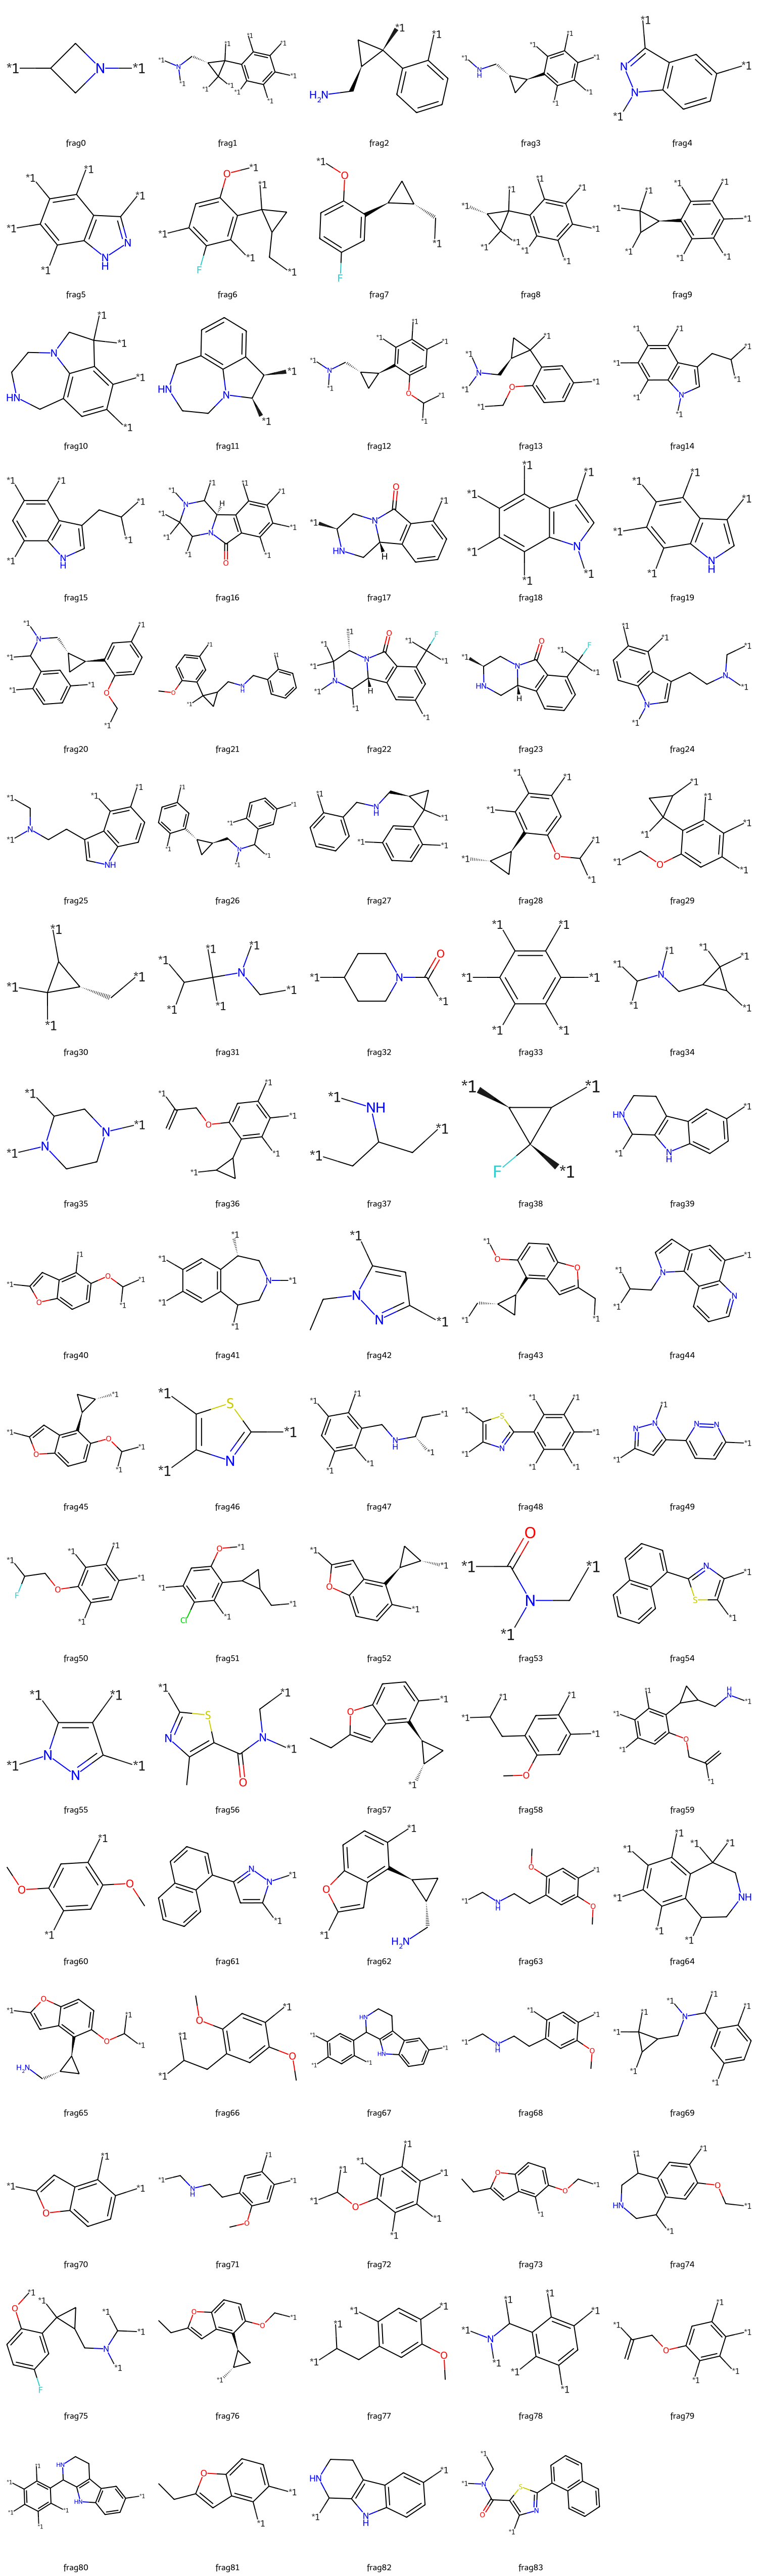

In [34]:
print(vocab_fragment_mmpa)
draw_fragment_mmpa = [f.mol for f in vocab_fragment_mmpa.values()]
print(len(draw_fragment_mmpa))
legends_mmpa = [f"frag{idx}" for idx in range(len(draw_fragment_mmpa))]

display(DrawMolsZoomed(draw_fragment_mmpa, legends=legends_mmpa, molsPerRow=5))


In [8]:
grammar_auto_mmpa = gsf.GroupGrammar(vocab=vocab_fragment_mmpa)

### mmpa fragmentation on chembl data

In [9]:
encode_input = [Chem.MolFromSmiles(smiles) for smiles in combine_psy_nonpsy["Smiles"]]

In [10]:
group_selfie_mmpa = []
extracted_groups_mmpa = []


for smiles in encode_input:
    encode_mol = grammar_auto_mmpa.full_encoder(smiles)
    group_selfie_mmpa.append(encode_mol)
    extracted = grammar_auto_mmpa.extract_groups(smiles)
    extracted_group = [group.name for group, _, _ in extracted]
    extracted_groups_mmpa.append(extracted_group)
    print(extracted_group)

print(extracted_groups_mmpa)


['frag72', 'frag55', 'frag31']
['frag72', 'frag55', 'frag0', 'frag31']
['frag55', 'frag31', 'frag31']
['frag72']
['frag12']
['frag72']
['frag33', 'frag35']
['frag72', 'frag31']
['frag33', 'frag31']
['frag33']
['frag33']
['frag33', 'frag31']
['frag67']
['frag67']
['frag67']
['frag67']
['frag67']
['frag39']
['frag39']
['frag64']
['frag24']
['frag64']
['frag64']
['frag33', 'frag35']
[]
['frag64']
['frag64']
['frag41']
['frag72']
['frag72', 'frag31']
['frag72', 'frag31']
['frag33', 'frag31']
['frag33', 'frag31']
['frag33', 'frag31']
['frag72', 'frag33']
['frag72', 'frag33']
['frag72']
['frag72']
['frag33']
['frag33']
['frag33', 'frag31']
['frag33', 'frag31']
['frag46', 'frag31']
['frag33', 'frag46', 'frag31']
['frag56', 'frag33']
['frag64']
['frag64', 'frag33']
['frag33']
['frag64']
['frag51']
['frag33']
['frag33', 'frag31']
['frag33', 'frag31']
['frag64']
['frag33', 'frag31']
['frag64']
['frag33', 'frag31']
['frag64']
['frag33']
['frag33']
['frag33']
['frag33']
['frag33']
['frag33']
['fra

### one-hot encoding

In [11]:
# Convert to DataFrame with a single column
df = pd.DataFrame({"Fragments": extracted_groups_mmpa})

# Explode the lists to get one fragment per row
df_exploded = df.explode("Fragments")

# Perform one-hot encoding
one_hot = pd.get_dummies(df_exploded["Fragments"], prefix="frag")

# Group by the original index to aggregate back to list-level encoding
one_hot_encoded = one_hot.groupby(level=0).max().astype(int)

# Print the result
print(one_hot_encoded)
one_hot_encoded.to_csv("psy_nonpsy_onehot.csv")


     frag_frag0  frag_frag1  frag_frag10  frag_frag11  frag_frag12  \
0             0           0            0            0            0   
1             1           0            0            0            0   
2             0           0            0            0            0   
3             0           0            0            0            0   
4             0           0            0            0            1   
..          ...         ...          ...          ...          ...   
835           0           0            0            0            0   
836           0           0            0            0            0   
837           0           0            0            0            0   
838           0           0            0            0            0   
839           0           0            0            0            0   

     frag_frag14  frag_frag16  frag_frag18  frag_frag20  frag_frag21  ...  \
0              0            0            0            0            0  ...   
1    

# Training

In [12]:
X = one_hot_encoded
y_label = (combine_psy_nonpsy["pChEMBL Value"] > 0).astype(int)
y_value = combine_psy_nonpsy["pChEMBL Value"]


print(X.shape, y_label.shape, y_value.shape)
print(X.head())
print(y_label.head())


(840, 48) (840,) (840,)
   frag_frag0  frag_frag1  frag_frag10  frag_frag11  frag_frag12  frag_frag14  \
0           0           0            0            0            0            0   
1           1           0            0            0            0            0   
2           0           0            0            0            0            0   
3           0           0            0            0            0            0   
4           0           0            0            0            1            0   

   frag_frag16  frag_frag18  frag_frag20  frag_frag21  ...  frag_frag66  \
0            0            0            0            0  ...            0   
1            0            0            0            0  ...            0   
2            0            0            0            0  ...            0   
3            0            0            0            0  ...            0   
4            0            0            0            0  ...            0   

   frag_frag67  frag_frag72  frag_frag

### Single Label

In [13]:
# Nested cross-validation setup
outer_ncv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_ncv = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)


# Define the objective function for the Inner loop
def objective(trial, X_train_inner, y_train_inner):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    max_depth = trial.suggest_int("max_depth", 5, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Create a random forest classifier
    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
    )

    # Cross-validation for hyperparameter tuning
    scoring = make_scorer(accuracy_score, greater_is_better=True)
    cv_scores = cross_val_score(
        rf_classifier, X_train_inner, y_train_inner, cv=inner_ncv, scoring=scoring
    )
    return cv_scores.mean()


[I 2025-01-19 11:21:45,082] A new study created in memory with name: no-name-adb96e10-92d2-46e7-9a58-4efa122ee689


[I 2025-01-19 11:21:45,348] Trial 0 finished with value: 0.7618352681039248 and parameters: {'n_estimators': 82, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 0.7618352681039248.
[I 2025-01-19 11:21:45,466] Trial 1 finished with value: 0.726113875069099 and parameters: {'n_estimators': 41, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 0.7618352681039248.
[I 2025-01-19 11:21:45,622] Trial 2 finished with value: 0.7633167495854063 and parameters: {'n_estimators': 40, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 2 with value: 0.7633167495854063.
[I 2025-01-19 11:21:45,725] Trial 3 finished with value: 0.7514096185737977 and parameters: {'n_estimators': 31, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 2 with value: 0.7633167495854063.
[I 2025-01-19 11:21

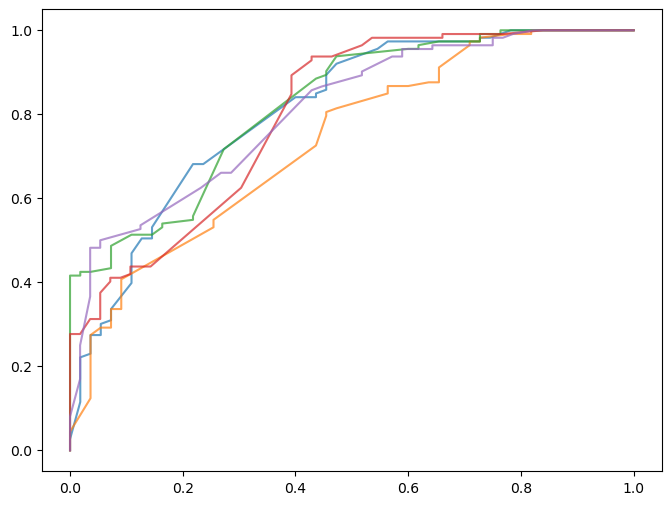

In [14]:
# Outer loop: Statistical evaluation
outer_scores = []
# ncv_label_scores = {label: [] for label in y.columns}

# For ROC plotting
mean_fpr = np.linspace(0, 1, 100)  # Average FPR for interpolation
tprs = []  # TPRs for all folds
aucs = []  # AUC scores for all folds

all_feature_importances = []
shap_values_list = []
shap_summary_data = []  # Store SHAP values for global summary plot

plt.figure(figsize=(8, 6))  # Initialize the plot

for fold, (train_index, test_index) in enumerate(outer_ncv.split(X, y_label), start=1):
    # Split data into training and testing sets for the outer fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_label.iloc[train_index], y_label.iloc[test_index]

    # Skip fold if only one class is present
    if len(np.unique(y_test)) < 2:
        print(
            f"Fold {fold}: Only one class present in y_test. Skipping ROC computation."
        )
        continue

    # Inner loop: Hyperparameter search
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)

    # Train the model using the best hyperparameters
    best_params = study.best_params
    best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
    best_rf_classifier.fit(X_train, y_train)

    # Store feature importances
    feature_importances = best_rf_classifier.feature_importances_
    all_feature_importances.append(feature_importances)

    # SHAP analysis
    explainer = shap.TreeExplainer(best_rf_classifier)
    shap_values = explainer.shap_values(X_test)
    shap_values_list.append(shap_values)

    # Aggregate SHAP values for summary (global analysis)
    shap_summary_data.append((shap_values, X_test))

    # Predict on the test set
    y_test_pred = best_rf_classifier.predict(X_test)
    y_test_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Plot ROC curve for the current fold
    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.2f})", alpha=0.7)

    # Interpolate TPR for consistent plotting
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    # Evaluate the model on the outer fold's test set
    outer_scores.append(
        {
            "accuracy": accuracy_score(y_test, y_test_pred),
            "f1_score": f1_score(y_test, y_test_pred, average="weighted"),
        }
    )


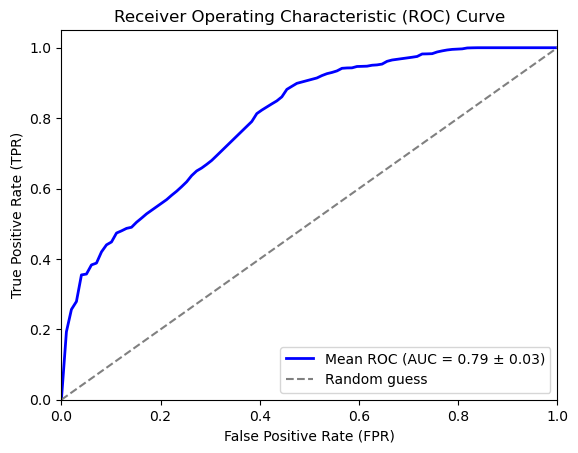

Accuracy: Mean = 0.77, Std = 0.03
F1_score: Mean = 0.75, Std = 0.03
Fold 1:
  accuracy: 0.7976
  f1_score: 0.7742
Fold 2:
  accuracy: 0.7262
  f1_score: 0.6979
Fold 3:
  accuracy: 0.7738
  f1_score: 0.7447
Fold 4:
  accuracy: 0.8036
  f1_score: 0.7805
Fold 5:
  accuracy: 0.7619
  f1_score: 0.7480


In [15]:
# Compute and plot mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure the curve ends at (1, 1)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(
    mean_fpr,
    mean_tpr,
    color="blue",
    lw=2,
    label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
)

# Add reference line and format the plot
plt.plot([0, 1], [0, 1], color="grey", linestyle="--", label="Random guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Calculate mean and standard deviation for overall metrics
metrics_summary = {
    key: [score[key] for score in outer_scores] for key in outer_scores[0]
}
for metric, values in metrics_summary.items():
    print(
        f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
    )

# Print final scores
for i, scores in enumerate(outer_scores):
    print(f"Fold {i+1}:")
    for metric, value in scores.items():
        print(f"  {metric}: {value:.4f}")


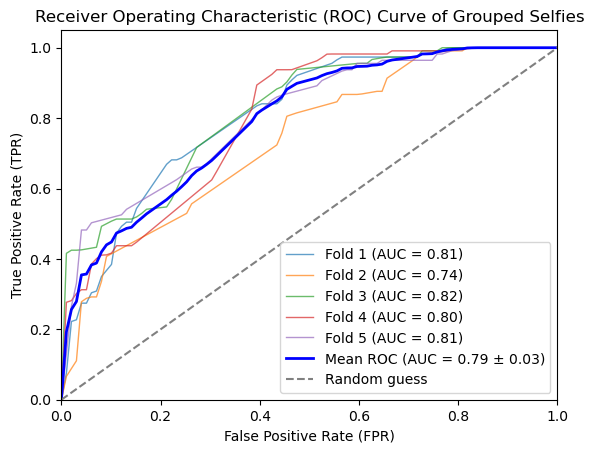

Accuracy: Mean = 0.77, Std = 0.03
F1_score: Mean = 0.75, Std = 0.03
Fold 1:
  accuracy: 0.7976
  f1_score: 0.7742
Fold 2:
  accuracy: 0.7262
  f1_score: 0.6979
Fold 3:
  accuracy: 0.7738
  f1_score: 0.7447
Fold 4:
  accuracy: 0.8036
  f1_score: 0.7805
Fold 5:
  accuracy: 0.7619
  f1_score: 0.7480


In [23]:
# Compute and plot ROC curve for each fold
# plt.figure(figsize=(10, 8))
for fold, tpr in enumerate(tprs, start=1):
    # Plot each fold's ROC curve
    plt.plot(
        mean_fpr,
        tpr,
        lw=1,
        alpha=0.7,
        label=f"Fold {fold} (AUC = {aucs[fold-1]:.2f})",
    )
    
# Compute and plot mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure the curve ends at (1, 1)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot the mean ROC curve
plt.plot(
    mean_fpr,
    mean_tpr,
    color="blue",
    lw=2,
    label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
)

# Add reference line and format the plot
plt.plot([0, 1], [0, 1], color="grey", linestyle="--", label="Random guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve of Grouped Selfies")
plt.legend(loc="lower right")
plt.show()

# Calculate mean and standard deviation for overall metrics
metrics_summary = {
    key: [score[key] for score in outer_scores] for key in outer_scores[0]
}
for metric, values in metrics_summary.items():
    print(
        f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
    )

# Print final scores
for i, scores in enumerate(outer_scores):
    print(f"Fold {i+1}:")
    for metric, value in scores.items():
        print(f"  {metric}: {value:.4f}")


In [17]:
print(best_params)

{'n_estimators': 24, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': True}


### Feature importance

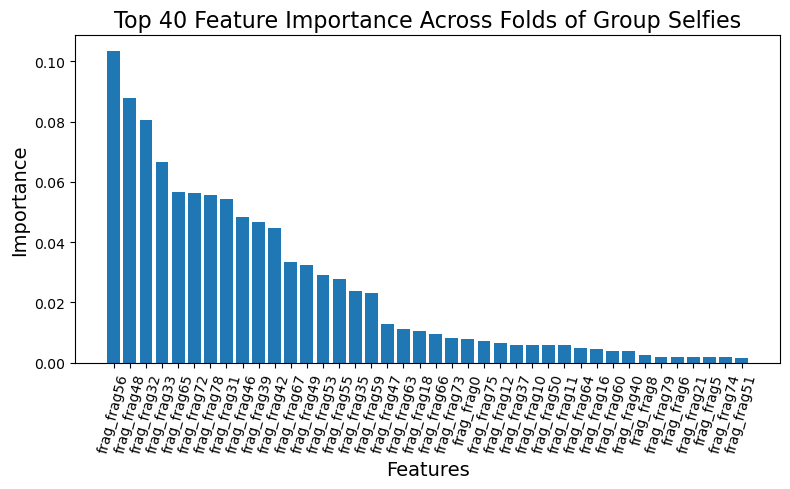

Top 40 Feature Importances (averaged across folds) of Group Selfies:
frag_frag56: 0.1035
frag_frag48: 0.0878
frag_frag32: 0.0806
frag_frag33: 0.0667
frag_frag65: 0.0565
frag_frag72: 0.0564
frag_frag78: 0.0556
frag_frag31: 0.0544
frag_frag46: 0.0483
frag_frag39: 0.0467
frag_frag42: 0.0448
frag_frag67: 0.0333
frag_frag49: 0.0323
frag_frag53: 0.0293
frag_frag55: 0.0279
frag_frag35: 0.0238
frag_frag59: 0.0231
frag_frag47: 0.0129
frag_frag63: 0.0111
frag_frag18: 0.0104
frag_frag66: 0.0096
frag_frag73: 0.0081
frag_frag0: 0.0080
frag_frag75: 0.0073
frag_frag12: 0.0064
frag_frag37: 0.0060
frag_frag10: 0.0059
frag_frag50: 0.0058
frag_frag11: 0.0057
frag_frag64: 0.0049
frag_frag16: 0.0044
frag_frag60: 0.0038
frag_frag40: 0.0037
frag_frag8: 0.0026
frag_frag79: 0.0019
frag_frag6: 0.0019
frag_frag21: 0.0018
frag_frag5: 0.0018
frag_frag74: 0.0018
frag_frag51: 0.0016


In [30]:
# Compute and visualize averaged feature importance
avg_feature_importances = np.mean(all_feature_importances, axis=0)
sorted_indices = np.argsort(avg_feature_importances)[::-1]
sorted_features = X.columns[sorted_indices]

N = 40  # Number of features to plot

# Select top N features
top_indices = sorted_indices[:N]
top_features = sorted_features[:N]
top_importances = avg_feature_importances[top_indices]


# Plot top N feature importance
plt.figure(figsize=(8, 5))
plt.bar(range(N), top_importances, align="center")
plt.xticks(range(N), top_features, rotation=75, fontsize = 10)
plt.title(f"Top {N} Feature Importance Across Folds of Group Selfies", fontsize=16)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Importance", fontsize=14)
plt.tight_layout()
plt.show()

# Output the sorted feature importance for top N features
print(f"Top {N} Feature Importances (averaged across folds) of Group Selfies:")
for feature, importance in zip(top_features, top_importances):
    print(f"{feature}: {importance:.4f}")
